**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [32]:
data = pd.read_csv('retail_trains.csv')

In [23]:
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

In [18]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [26]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

In [27]:
VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [33]:
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [34]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [35]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [36]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [37]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

/content/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


In [38]:
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


In [39]:
recommender = MainRecommender(data_train_matcher)

GPU training requires factor size to be a multiple of 32. Increasing factors from 20 to 32.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [40]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1106523, 1044078, 883932, 854852]

In [41]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [42]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 841220, 907099, 1103105]

In [43]:
recommender.get_similar_users_recommendation(2375, N=5)

[10198378, 1096573, 1055403, 861494, 970160]

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

In [45]:
ACTUAL_COL = 'actual'

In [46]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [47]:
N_PREDICT = 50 

In [48]:
%%time
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

CPU times: user 33.1 s, sys: 21.1 s, total: 54.2 s
Wall time: 30.3 s


In [49]:
%%time
result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

CPU times: user 6min 3s, sys: 3min 48s, total: 9min 51s
Wall time: 5min 39s


In [44]:
def evalRecall(df_result, target_col_name, recommend_model):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=25))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()
        
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@50 of matching

In [50]:
TOPK_RECALL = 50

In [51]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.06525657038145175),
 ('als_rec', 0.05187259124644071),
 ('sim_item_rec', 0.03898912723990598),
 ('sim_user_rec', 0.007292481229374147)]

### Precision@5 of matching

In [52]:
TOPK_PRECISION = 5

In [53]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.17712691771268974),
 ('als_rec', 0.12264063226406197),
 ('sim_item_rec', 0.07261738726173878),
 ('sim_user_rec', 0.01580660158066013)]

In [55]:
list = pd.DataFrame()

In [65]:
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=20))
recall = result_eval_matcher.apply(lambda row: recall_at_k(row['own_rec'], row[ACTUAL_COL], k=20), axis=1).mean()
list = list.append(pd.DataFrame([recall], columns=['recall'], index=[20]))

In [66]:
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=50))
recall = result_eval_matcher.apply(lambda row: recall_at_k(row['own_rec'], row[ACTUAL_COL], k=50), axis=1).mean()
list = list.append(pd.DataFrame([recall], columns=['recall'], index=[50]))

In [68]:
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=100))
recall = result_eval_matcher.apply(lambda row: recall_at_k(row['own_rec'], row[ACTUAL_COL], k=100), axis=1).mean()
list = list.append(pd.DataFrame([recall], columns=['recall'], index=[100]))

In [69]:
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=200))
recall = result_eval_matcher.apply(lambda row: recall_at_k(row['own_rec'], row[ACTUAL_COL], k=200), axis=1).mean()
list = list.append(pd.DataFrame([recall], columns=['recall'], index=[200]))

In [70]:
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=500))
recall = result_eval_matcher.apply(lambda row: recall_at_k(row['own_rec'], row[ACTUAL_COL], k=500), axis=1).mean()
list = list.append(pd.DataFrame([recall], columns=['recall'], index=[500]))

In [71]:
list

,recall
20,0.039284
50,0.065257
100,0.096045
200,0.135373
500,0.182053


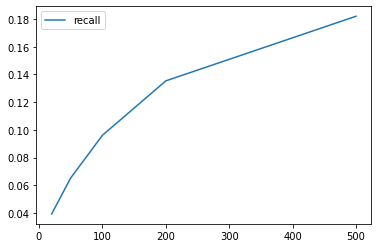

In [72]:
list.plot()

Исходя из графика можно сделать вывод, что наилучшим значением будет 200. Так как после 200 график начинает расти медленнее 

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

In [73]:
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [74]:
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [75]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [76]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [77]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [78]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


In [79]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (107550, 2) Users: 2151 Items: 4574


In [80]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [81]:
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


In [82]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [83]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [84]:
user_sales_count = data_train_ranker.groupby('user_id')['sales_value'].count().reset_index()
user_sales_count.rename(columns={'sales_value': 'sales_count'}, inplace=True)
df_ranker_train = df_ranker_train.merge(user_sales_count, on='user_id', how='left')

In [85]:
user_sales_count_per_week = data_train_ranker.groupby(['user_id'])['week_no'].nunique().reset_index()
user_sales_count_per_week.rename(columns={'week_no': 'sales_count_per_week'}, inplace=True)
user_sales_count_per_week['sales_count_per_week'] = (user_sales_count['sales_count'] / user_sales_count_per_week['sales_count_per_week']).astype(int)
df_ranker_train = df_ranker_train.merge(user_sales_count_per_week, on='user_id', how='left')

In [86]:
item_sales_count = data_train_ranker.groupby('item_id')['sales_value'].count().reset_index()
item_sales_count.rename(columns={'sales_value': 'i_sales_count'}, inplace=True)
df_ranker_train = df_ranker_train.merge(item_sales_count, on='item_id', how='left')

In [87]:
item_sales_count_per_week = data_train_ranker.groupby(['item_id'])['week_no'].nunique().reset_index()
item_sales_count_per_week.rename(columns={'week_no': 'i_sales_count_per_week'}, inplace=True)
item_sales_count_per_week['i_sales_count_per_week'] = (item_sales_count['i_sales_count'] / item_sales_count_per_week['i_sales_count_per_week']).astype(int)
df_ranker_train = df_ranker_train.merge(item_sales_count_per_week, on='item_id', how='left')

In [91]:
item_price = (data_train_ranker.groupby('item_id')['sales_value'].sum() / data_train_ranker.groupby('item_id')['quantity'].sum()).reset_index()
item_price.columns = ['item_id', 'item_price']
df_ranker_train = df_ranker_train.merge(item_price, on='item_id', how='left')

In [92]:
df_ranker_train.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,sales_count,sales_count_per_week,i_sales_count,i_sales_count_per_week,item_price
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,204,34,3.0,1.0,3.99
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,204,34,1.0,1.0,10.99
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,204,34,NaN,NaN,NaN
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,204,34,NaN,NaN,NaN
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,204,34,10.0,2.0,7.99


In [93]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [94]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'sales_count',
 'sales_count_per_week',
 'i_sales_count',
 'i_sales_count_per_week',
 'item_price']

In [95]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats,
                     n_jobs=-1,
#                      verbose=0
                   )

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [96]:
df_ranker_predict = df_ranker_train.copy()

In [97]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [98]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [99]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 5.81 s, sys: 69.2 ms, total: 5.88 s
Wall time: 5.91 s


In [100]:
sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1444117647058813)]

In [101]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [102]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [103]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.18684073107049418)
('own_rec', 0.1444117647058813)


/content/metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)
